In [421]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

In [422]:
#Ground truth data distribution
def random_sample(d, Delta, N):
    y = np.random.randint(0,2,N)
    y = np.where(y==0, -1, y)
    x = np.zeros((N,d))
    for i in range(N):
        if y[i] == 1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d))
        if y[i] == -1:
            x[i,:] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d))
    return x.reshape(N,d),y

In [423]:
#activation function
def sigma(t, t1, s1, t2, s2):
    if t < t1:
        return s1
    elif t>t2:
        return s2
    else:
        return (s2-s1)/(t2-t1)*(t-t1)+s1
    
def grad_sigma(t, t1, s1, t2, s2):
    if t < t1:
        return 0
    elif t>t2:
        return 0
    else:
        return (s2-s1)/(t2-t1)
vgrad_sigma = np.vectorize(grad_sigma)
vsigma = np.vectorize(sigma)

In [424]:
#two layer neural net
def neural_net(x, θ):
    out = vsigma(θ@x, 0.5, -2.5, 1.5, 7.5)
    return np.mean(out)

In [425]:
def stochastic_gradient_descent(weights, d, Delta, N, epsilon = 1e-6, num_epochs = 1000):
    for epoch in trange(num_epochs): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        X = sample[0].reshape(d,1)
        y = sample[1]
        vgrad = vgrad_sigma(weights@X, 0.5, -2.5, 1.5, 7.5)
        gradient = vgrad.reshape(N,1)*(X).reshape(1,d)
        weights += 2*epsilon*(y-neural_net(X, weights))*gradient
                
    return weights

In [427]:
#params
d = 40
N = 800
Delta = 0.8

# Initialize random weights

weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)

weights = stochastic_gradient_descent(weights, d, Delta, N, epsilon = 1e-6, num_epochs = int(1e7))

  0%|          | 0/10000000 [00:00<?, ?it/s]

In [428]:
weights_norms = np.linalg.norm(weights, axis = 1)

(array([0.7846416 , 0.        , 0.01376564, 0.        , 0.00688282,
        0.00688282, 0.01376564, 0.02064846, 0.03441411, 0.04817975,
        0.04129693, 0.02064846, 0.07571103, 0.07571103, 0.06882821,
        0.09635949, 0.14453924, 0.15830488, 0.2615472 , 0.20648463,
        0.34414105, 0.37855516, 0.43361773, 0.57127415, 0.57815697,
        0.57815697, 0.32349259, 0.15142206, 0.05506257, 0.01376564]),
 array([0.06873378, 0.25034536, 0.43195694, 0.61356852, 0.7951801 ,
        0.97679167, 1.15840325, 1.34001483, 1.52162641, 1.70323799,
        1.88484957, 2.06646115, 2.24807273, 2.42968431, 2.61129589,
        2.79290747, 2.97451905, 3.15613063, 3.33774221, 3.51935379,
        3.70096537, 3.88257695, 4.06418853, 4.24580011, 4.42741169,
        4.60902327, 4.79063485, 4.97224643, 5.153858  , 5.33546958,
        5.51708116]),
 <BarContainer object of 30 artists>)

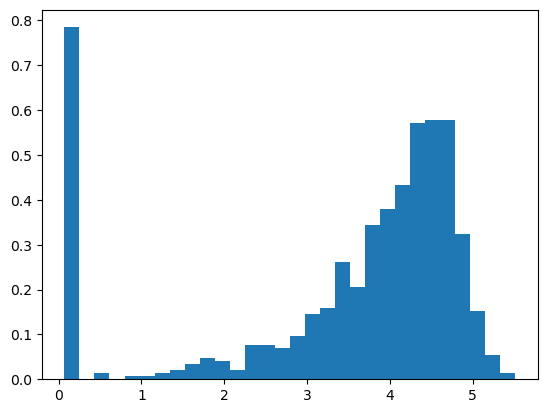

In [441]:
import matplotlib.pyplot as plt 
plt.hist(weights_norms, density = True,  bins = 30)

In [440]:
sample = random_sample(40, 0.8, 1)
x = sample[0][0]
y = sample[1]
print("pred: "+ str(neural_net(x, weights)))
print("actual:" + str(y))

pred: 1.4029951168440733
actual:[1]


In [402]:
from scipy.stats import norm

def q_plus(t, Delta):
    x = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 + Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral -2.5*norm.cdf(0.5/((1+Delta)*t))+7.5*(1-norm.cdf(1.5/((1+Delta)*t)))
    #return integral

def q_minus(t, Delta):
    x = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f = 1 / (np.sqrt(2 * np.pi)) * vsigma((1 - Delta) * t * x, 0.5, -2.5, 1.5, 7.5) * np.exp(-x ** 2 / 2)
    integral = np.trapz(f, x)
    return integral -2.5*norm.cdf(0.5/((1-Delta)*t))+7.5*(1-norm.cdf(1.5/((1-Delta)*t)))
    #return integral

vq_plus = np.vectorize(q_plus)
vq_minus = np.vectorize(q_minus)

def dq_plus(t, Delta):
    x = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f = (1+Delta) / (np.sqrt(2 * np.pi)) * 10 * np.exp(-x ** 2 / 2)*x
    integral = np.trapz(f, x)
    return integral 

def dq_minus(t, Delta):
    x = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f = (1-Delta) / (np.sqrt(2 * np.pi)) * 10 * np.exp(-x ** 2 / 2)*x
    integral = np.trapz(f, x)
    return integral
    
vdq_plus = np.vectorize(dq_plus)
vdq_minus = np.vectorize(dq_minus)

def q_func(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus(t,0.8)
    elif flag == 1:
        return vq_minus(t,0.8)
    elif flag == 2:
        return vdq_plus(t,0.8)
    elif flag == 3:
        return vdq_minus(t,0.8)
    
def q_func_new(pair):
    t = pair[0]
    flag = pair[1]
    if flag == 0:
        return vq_plus_new(t)
    elif flag == 1:
        return vq_minus_new(t)
    elif flag == 2:
        return vdq_plus_new(t)
    elif flag == 3:
        return vdq_minus_new(t)

def parallelise(t):
    with Pool(4) as p:
        results = np.array(p.map(q_func_new, [[t,0], [t,1], [t,2], [t,3]]))
    return results
vparallelise = np.vectorize(parallelise)

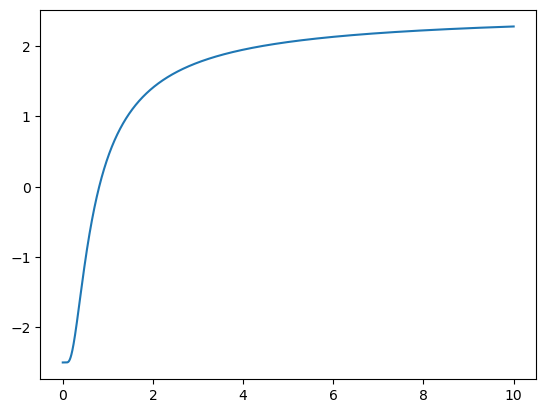

In [380]:
epsilon = 1e-6
Delta = 0.8
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_plus_vals = vq_plus(Interval_q, Delta)
plt.plot(Interval_q, q_plus_vals)

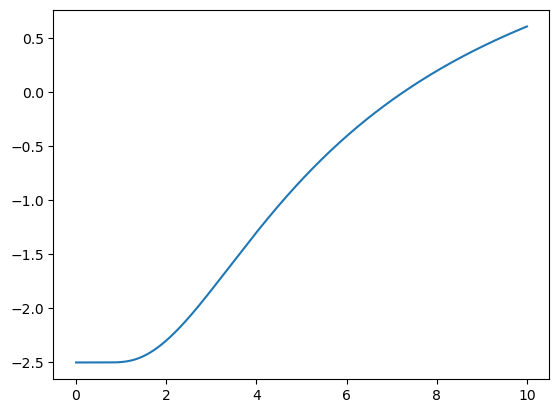

In [381]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_minus_vals = vq_minus(Interval_q, Delta)
plt.plot(Interval_q, q_minus_vals)

In [382]:
Q_plus = dict(zip(Interval_q, q_plus_vals))
Q_minus = dict(zip(Interval_q, q_minus_vals))

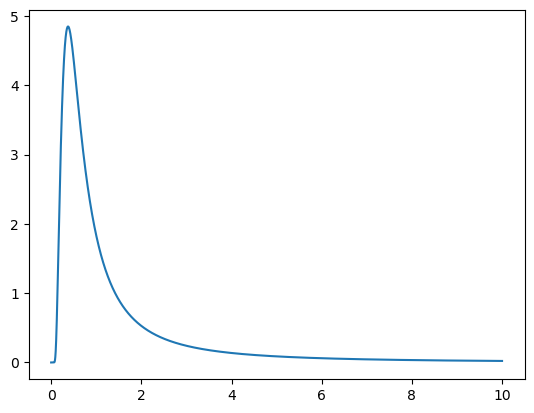

In [394]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_plus_vals = vdq_plus(Interval_q, Delta)
plt.plot(Interval_q, dq_plus_vals)

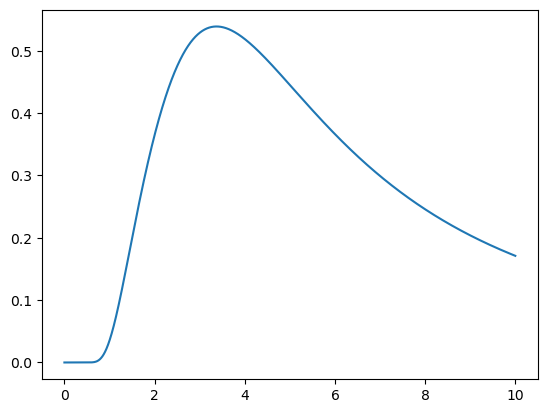

In [392]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_minus_vals = vdq_minus(Interval_q, Delta)
plt.plot(Interval_q, dq_minus_vals)

In [395]:
dQ_plus = dict(zip(Interval_q, dq_plus_vals))
dQ_minus = dict(zip(Interval_q, dq_minus_vals))

In [396]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
vfind_nearest = np.vectorize(find_nearest)

In [238]:
def q_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_plus[r_approx]

def q_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_minus[r_approx]

vq_plus_new = np.vectorize(q_plus_new)
vq_minus_new = np.vectorize(q_minus_new)

def dq_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_plus[r_approx]

def dq_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_minus[r_approx]

vdq_plus_new = np.vectorize(dq_plus_new)
vdq_minus_new = np.vectorize(dq_minus_new)


def R_inf(vq_plus, vq_minus, Delta):
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return 0.5 * (1 - mean_vq_plus) ** 2 + 0.5 * (1 + mean_vq_minus) ** 2

def grad_R_inf(r, vq_plus, vq_minus, dplus, dminus, Delta):
    J = len(r)
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return -1 / J * dplus * (1 - mean_vq_plus) + 1 / J * dminus * (1 + mean_vq_minus)

def update(r, dt, grad):
    J = len(r)
    return r - J * grad * dt

In [412]:
#simulate pde
epsilon = 1e-6
Interval = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e3))
J = 400
Iters = 5
pde_vals = np.zeros((Iters,J))
Delta = 0.8
d = 40
separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]

In [413]:
#simulate 100 times and obtain a histogram
processes_count = 4
for i in trange(Iters):
    Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    for dt in tqdm(separations):
        ''''
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        dplus = vdq_plus(r, Delta)
        dminus = vdq_minus(r, Delta)
        '''
        output = parallelise(r).reshape(4,J)
        plus = output[0]
        minus = output[1]
        dplus = output[2]
        dminus = output[3]
        
        grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
        r = update(r,dt, grad)
    pde_vals[i] = r

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

(array([0.71595808, 0.00540346, 0.00270173, 0.00270173, 0.00540346,
        0.00540346, 0.02161383, 0.01350864, 0.01350864, 0.02161383,
        0.03512247, 0.05403457, 0.0378242 , 0.06213976, 0.07835013,
        0.08645532, 0.12427952, 0.189121  , 0.18101582, 0.25396249,
        0.31610225, 0.35932991, 0.46469732, 0.61599413, 0.54574918,
        0.49171461, 0.37554028, 0.24315558, 0.06213976, 0.0189121 ]),
 array([-0.08483525,  0.10023145,  0.28529815,  0.47036485,  0.65543155,
         0.84049825,  1.02556495,  1.21063165,  1.39569835,  1.58076505,
         1.76583175,  1.95089845,  2.13596515,  2.32103185,  2.50609855,
         2.69116525,  2.87623195,  3.06129865,  3.24636535,  3.43143205,
         3.61649875,  3.80156545,  3.98663215,  4.17169885,  4.35676555,
         4.54183225,  4.72689895,  4.91196565,  5.09703235,  5.28209905,
         5.46716576]),
 <BarContainer object of 30 artists>)

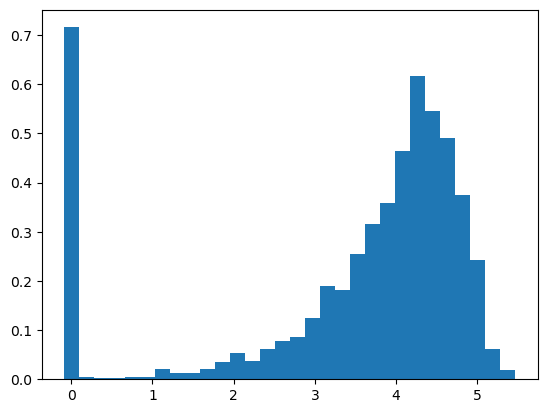

In [442]:
import matplotlib.pyplot as plt
y = np.ndarray.flatten(pde_vals)
plt.hist(y, density = True, bins = 30)

In [449]:
Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
r = np.linalg.norm(Z, axis = 1)
start = time.time()
plus = vq_plus_new(r)
minus = vq_minus_new(r)
dplus = vdq_plus_new(r)
dminus = vdq_minus_new(r)
print('Elapsed time: {}'.format(time.time()-start))

Elapsed time: 0.19214320182800293


In [450]:
Z = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), J).reshape(J, d)
r = np.linalg.norm(Z, axis = 1)
start = time.time()
output = parallelise(r).reshape(4,J)
plus = output[0]
minus = output[1]
dplus = output[2]
dminus = output[3]
print('Elapsed time: {}'.format(time.time()-start))

Elapsed time: 0.23653006553649902
